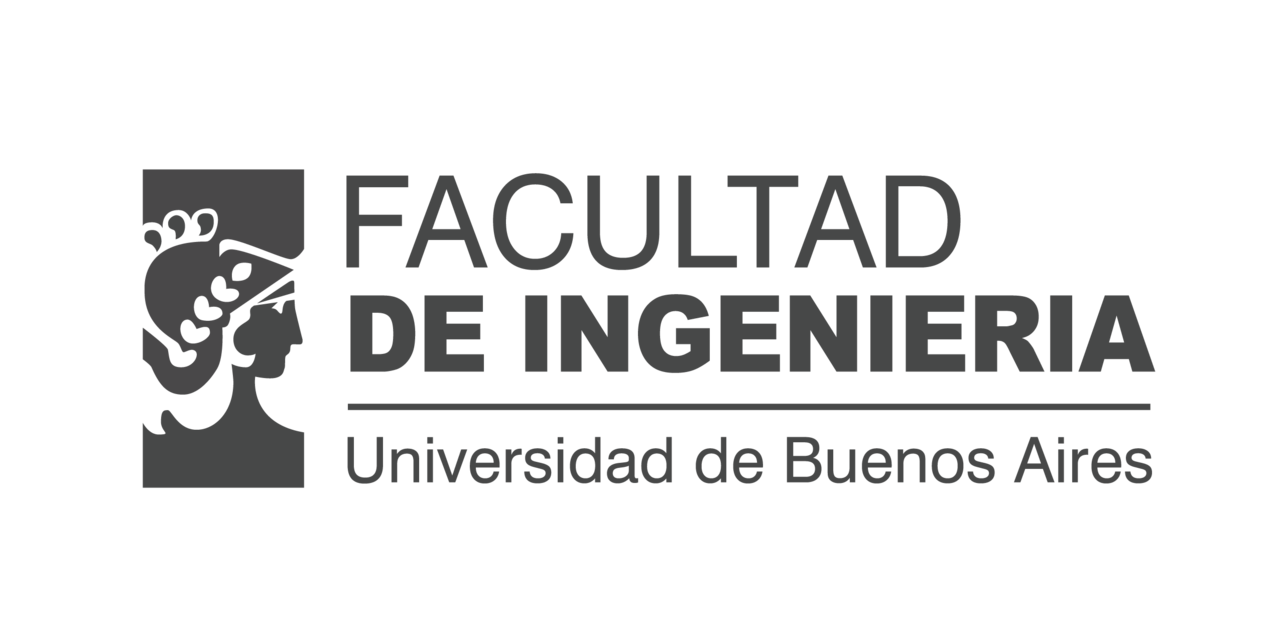

**Profesores:** <br />
Ing. Maxim Dorogov - mdorogov@fi.uba.ar <br />
Esp. Ing. Leandro Torrent - ingtorrentleandro@gmail.com <br />

**Alumnos:** <br />
Ing. Pablo Martin Gomez Verdini - gomezpablo86@gmail.com <br />
Ing. Diego Paciotti Iacchelli - diegopaciotti@gmail.com  <br />
Mg. Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/FIUBA-CEIA-18Co2024/VpC1-TP3 <br />

# TP 3: Enunciado

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.


## Instalación de librerías

In [146]:
%pip install opencv-contrib-python # SIFT
%pip install opencv-python
%pip install matplotlib
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Imports

In [147]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

import os
import glob

# Desarrollo del Trabajo Práctico

## Punto 1: Detección única con Template Matching

### Objetivo

El objetivo del pipeline es detectar la mejor coincidencia única de un patrón o *template* dentro de un conjunto de imágenes, utilizando la técnica de Template Matching de OpenCV, y visualizar el resultado sobre cada imagen.

### Transformaciones aplicadas

#### Redimensionamiento del template
Antes de aplicar el algoritmo de coincidencia, se redimensiona el template a un tamaño específico definido por la entrada `params`. Esto permite adaptar el patrón a las proporciones del objeto a detectar en cada imagen, mejorando la precisión del matching.

#### Inversión del template (opcional)
Si `params[2] == 1`, se invierte el template aplicando `255 - template`. Esto es útil para detectar versiones del objeto en negativo o con contraste invertido (por ejemplo, blanco sobre negro en lugar de negro sobre blanco).

#### Selección del canal rojo
Se realiza la búsqueda de coincidencia únicamente sobre el canal rojo (`img[:, :, 2]`). Esta decisión se basa en que dicho canal puede ofrecer mayor contraste o definición del objeto buscado, según el contexto de las imágenes.

### Preprocesamiento y heurística

Para cada imagen del conjunto:

- Se carga y convierte a RGB para visualización.
- Se obtienen parámetros personalizados (ancho, alto, inversión) desde un diccionario `dict_template_size`.
- Se aplica la función `matching`, que:
  - Calcula el mapa de similitud (`res`).
  - Dibuja el rectángulo de detección sobre la imagen.
  - Muestra el score máximo (`max_val`) como indicador de calidad de coincidencia.

### Métrica utilizada para detección

Se utiliza `cv.TM_CCOEFF_NORMED`. Las razones de su elección:

- Invariante a cambios de brillo, ya que elimina la media local del template y de la región evaluada.
- Normalizada, lo que facilita comparar scores entre imágenes.
- Adecuada para detecciones precisas cuando el patrón tiene buena visibilidad.

In [148]:
def matching(img, template, params):    
# Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
    template_resized = cv.resize(template, (params[0], params[1]))
    if params[2]:
        template_resized = 255 - template_resized
    w, h = template_resized.shape[::-1]
    img_salida = img.copy()
    # Aplicamos la coincidencia de patrones
    #--------------------------------------
    res = cv.matchTemplate(img[:, :, 2], template_resized, cv.TM_CCOEFF_NORMED) # Busco el canal rojo
    # Encontramos los valores máximos y mínimos
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    score = max_val
    top_left = max_loc
    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img_salida,top_left, bottom_right, (0, 255, 0), 2)
    # Graficamos el procesamiento y la salida
    #----------------------------------------
    plt.figure()
    # Resultado de coincidencia
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    # Imagen original con recuadros
    plt.subplot(122),plt.imshow(img_salida)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.show()
    display(f"Score: {score}")

['data/images/coca_logo_2.png', 'data/images/coca_multi.png', 'data/images/coca_retro_2.png', 'data/images/coca_logo_1.png', 'data/images/coca_retro_1.png', 'data/images/logo_1.png']


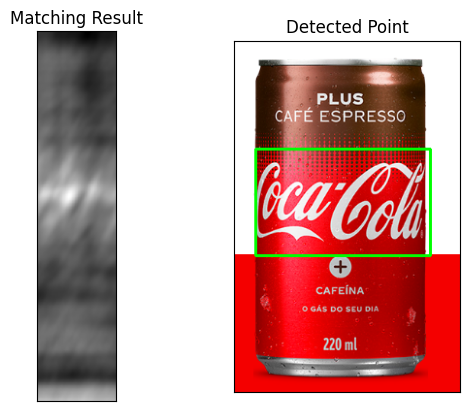

'Score: 0.2896941900253296'

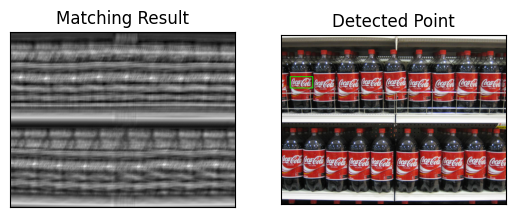

'Score: 0.5213674902915955'

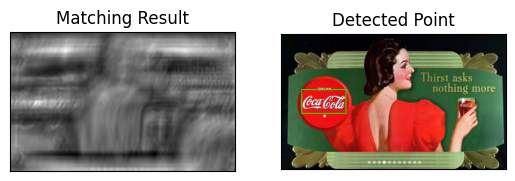

'Score: 0.4728694260120392'

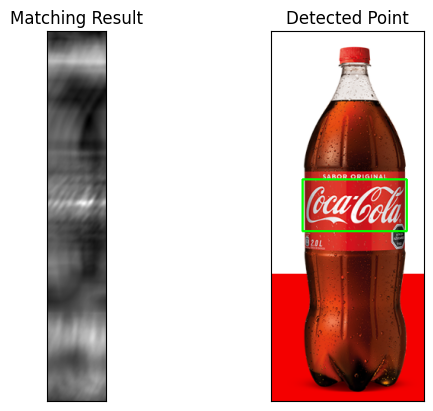

'Score: 0.3034612536430359'

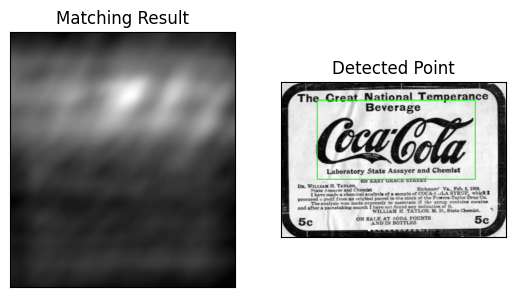

'Score: 0.4373584985733032'

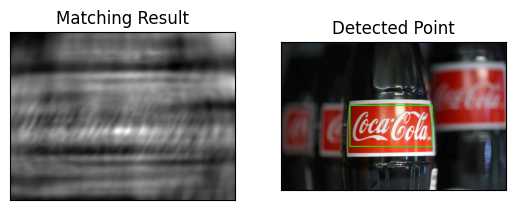

'Score: 0.375218003988266'

In [149]:
def list_png_files(folder_path):
    png_files = glob.glob(os.path.join(folder_path, "*.png"))
    return png_files

folder_path = "data/images"
png_files = list_png_files(folder_path)
print(png_files)

dict_template_size = {
    'data/images/coca_logo_1.png' : [140, 70, 1],
    'data/images/coca_logo_2.png': [180, 110, 1],
    'data/images/coca_multi.png': [80, 40, 1],
    'data/images/coca_retro_1.png': [500, 250, 0],
    'data/images/coca_retro_2.png': [140, 75, 1],
    'data/images/logo_1.png': [250, 125, 1]
}

template = cv.imread('data/template/pattern.png')
template = template[:, :, 0]

for file in png_files:
    img = cv.imread(file)
    img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)
    matching(img_rgb, template, dict_template_size[file])   

## Punto 2: Detección múltiple con Template Matching

### Objetivo

El objetivo de esta función es detectar múltiples apariciones de un patrón dentro de una misma imagen. En lugar de buscar una única coincidencia, se identifican todas las ubicaciones que superan cierto umbral de similitud.

### Transformaciones aplicadas

- Redimensionamiento del template: Se ajusta a un tamaño personalizado mediante `params`, permitiendo adaptarse a diferentes escalas del objeto.
- Inversión del template (opcional): Si se activa, se invierte para detectar versiones negativas del patrón.
- Selección del canal rojo: Se trabaja exclusivamente sobre el canal rojo por su mejor contraste en este problema.

### Métrica utilizada para detección

Se usa `cv.TM_CCOEFF_NORMED`, que:

- Evalúa la correlación entre la media local del template y la región de la imagen.
- Devuelve una matriz con valores entre -1 (anticorrelación perfecta) y 1 (correlación perfecta).
- Es robusta ante variaciones de iluminación.

### Criterio de detección

- Se calcula el valor máximo (`max_val`) en el mapa de similitud.
- Se define un umbral relativo como `threshold = max_val * 0.83`, valor empírico que balancea entre sensibilidad y precisión:
  - Umbral bajo: más coincidencias, pero riesgo de falsos positivos.
  - Umbral alto: menos falsos positivos, pero se pueden perder detecciones válidas.
- Se consideran válidas todas las ubicaciones donde `res >= threshold`.

In [150]:
def matching_multi(img, template, params):    
# Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
    print(f"Tomando tamaño para template {params[0]}x{params[1]}")
    template_resized = cv.resize(template, (params[0], params[1]))
    if params[2]:
        template_resized = 255 - template_resized
    w, h = template_resized.shape[::-1]
    img_salida = img.copy()
    # Aplicamos la coincidencia de patrones
    #--------------------------------------
    res = cv.matchTemplate(img[:, :, 2], template_resized, cv.TM_CCOEFF_NORMED) # Busco el canal rojo
    # Calculamos el umbral como el valor medio de la matriz resultante
    _, max_val, _, _ = cv.minMaxLoc(res)
    threshold = max_val * 0.83
    # Obtenemos todas las ubicaciones donde el score es mayor o igual al umbral
    loc = np.where(res >= threshold)
    # Para cada coordenada encontrada, dibujamos un rectángulo
    for pt in zip(*loc[::-1]):  # loc[::-1] invierte el orden para obtener (x, y)
        bottom_right = (pt[0] + w, pt[1] + h)
        cv.rectangle(img_salida, pt, bottom_right, (0, 255, 0), 1)
    
    score = np.mean(res[loc])
    print(f"Score all the image: {score}")
    print(f"Threshold for matching: {threshold}")
    # Graficamos los resultados:
    # (1) La matriz de resultados de la coincidencia
    # (2) La imagen original con todos los rectángulos dibujados
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.imshow(res, cmap='gray')
    plt.title('Matching Result')
    plt.xticks([]), plt.yticks([])
    
    plt.subplot(122)
    plt.imshow(img_salida)
    plt.title('Detected Points')
    plt.xticks([]), plt.yticks([])
    plt.show()

['data/images/coca_logo_2.png', 'data/images/coca_multi.png', 'data/images/coca_retro_2.png', 'data/images/coca_logo_1.png', 'data/images/coca_retro_1.png', 'data/images/logo_1.png']
Tomando tamaño para template 80x40
Score all the image: 0.45925313234329224
Threshold for matching: 0.4327350169420242


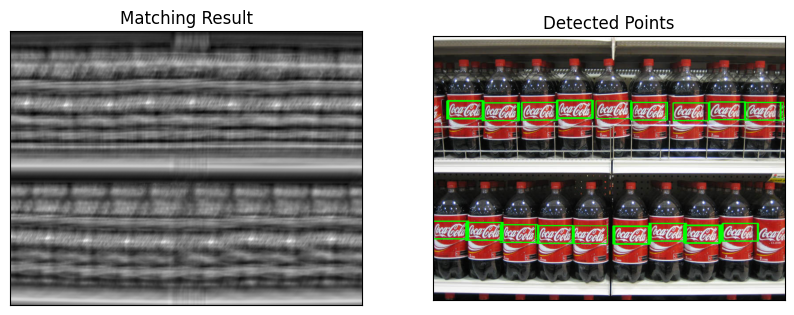

In [151]:
folder_path = "data/images"
png_files = list_png_files(folder_path)
print(png_files)

dict_template_size = {
    'data/images/coca_multi.png': [80, 40, 1],
}

template = cv.imread('data/template/pattern.png')
template = template[:, :, 0]
img = cv.imread('data/images/coca_multi.png')
img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)

matching_multi(img_rgb, template, [80, 40, 1]) 


## Punto 3: Heurísticas avanzadas, fallback y limitaciones

### Estrategia combinada

- Se utiliza SIFT para detecciones únicas con mayor robustez geométrica.
- Si el score de SIFT está por debajo de cierto umbral o falla la detección, se aplica un fallback a detección múltiple con template matching.
- Esta heurística permite cubrir ambos escenarios: patrones bien definidos (SIFT) y repetitivos o borrosos (template matching).

### Limitaciones observadas

- El score de template matching no siempre es representativo de una buena detección:
  - En casos con muchas detecciones incorrectas, el score puede seguir siendo alto.
- Para mitigar esto, se define un límite máximo de detecciones por imagen como guardarraíl ante este comportamiento errático.

### Sobre la escala del template

- Cuando el template se hace demasiado pequeño (en iteraciones de resize), comienza a correlacionar con fondos blancos u otras regiones irrelevantes, generando falsos positivos.
- Por esta razón, se limita el escalamiento inferior del template a un mínimo razonable.

### Pirámide de escalas vs. resize manual

- Se evaluó el uso de piramidado con `cv.pyrDown`, pero su escalamiento discreto (por mitades) no permitía alcanzar tamaños óptimos del template.
- Se optó por un resizing manual continuo que da mejor control sobre los tamaños a evaluar y mejora los resultados.

In [152]:
def matching_multi_invariante(img, template, params):    
    # Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
    template_resized = cv.resize(template, (params[0], params[1]))
    if params[2]:
        template_resized = 255 - template_resized
    w, h = template_resized.shape[::-1]
    # Aplicamos la coincidencia de patrones
    #--------------------------------------
    res = cv.matchTemplate(img, template_resized, cv.TM_CCOEFF_NORMED) # Busco el canal rojo
        # Calculamos el umbral como el valor medio de la matriz resultante
    _, max_val, _, _ = cv.minMaxLoc(res)
    threshold = max_val * 0.80
    # Obtenemos todas las ubicaciones donde el score es mayor o igual al umbral
    loc = np.where(res >= threshold)
    i =len([j for j in zip(*loc[::-1])])
    score = np.mean(res[loc])
    return {"score": score, "detecciones": i, "loc":loc, "w": w, "h": h, "res": res}

In [153]:
def template_matching_fallback(img_rgb, template):
    resultados=[]
    for i in range(template.shape[0], int(template.shape[0] * 0.2) ,-1):
        resultado = matching_multi_invariante(img_rgb, template, [ int(i*2), int(i), 0])
        resultados.append(resultado)
    # Sacás máximos para escalar
    max_detecciones = max(r["detecciones"] for r in resultados)
    # Función combinada normalizada
    def puntaje_normalizado(d, s, alpha=0.5):
        d_norm = d / max_detecciones
        return alpha * d_norm + (1 - alpha) * s
    # Elegís la mejor combinación
    filtrados = [x for x in resultados if x ["detecciones"] <= 200]
    mejor = max(filtrados, key=lambda x: puntaje_normalizado(x["detecciones"], x["score"], alpha=0.4))
    print(f'El mejor valor es {mejor["score"]} con una cantidad de detecciones {mejor["detecciones"]}')
    return mejor

Buenos matches: 31


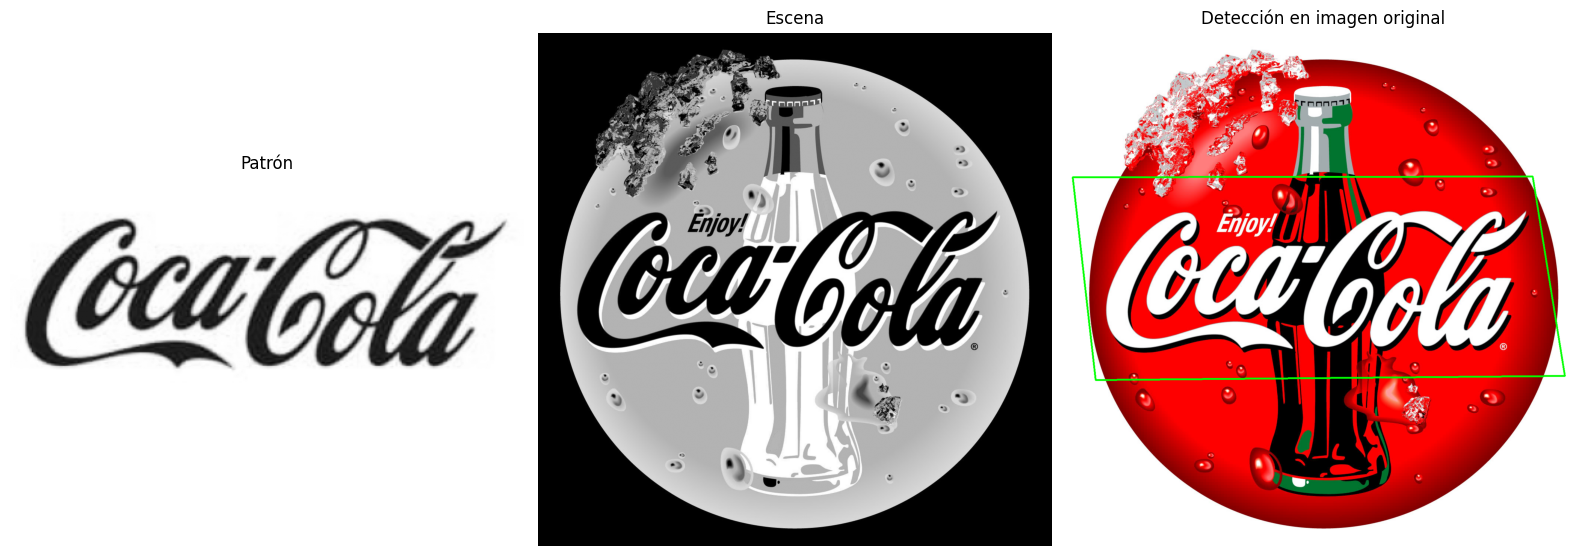

Buenos matches: 45


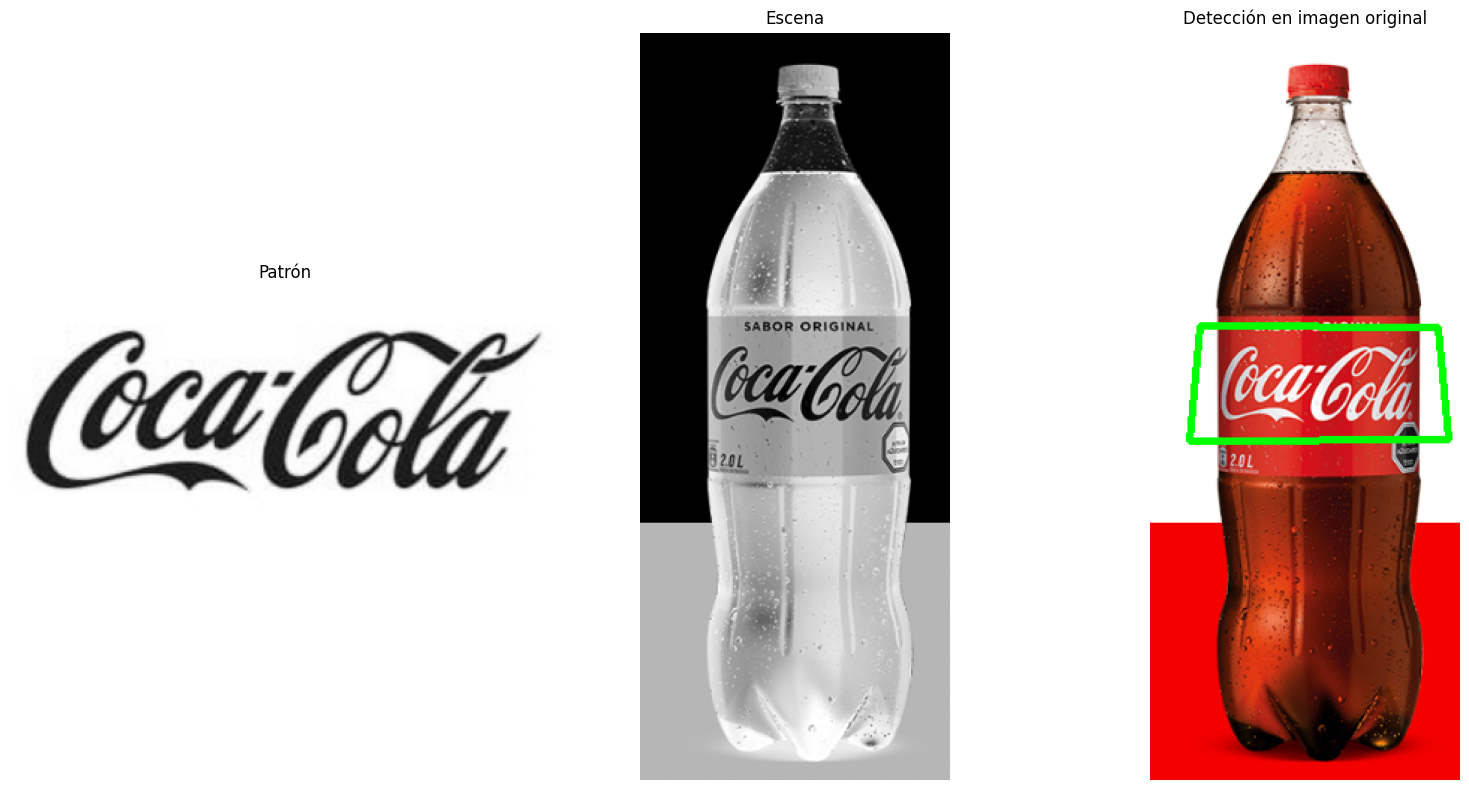

Buenos matches: 38


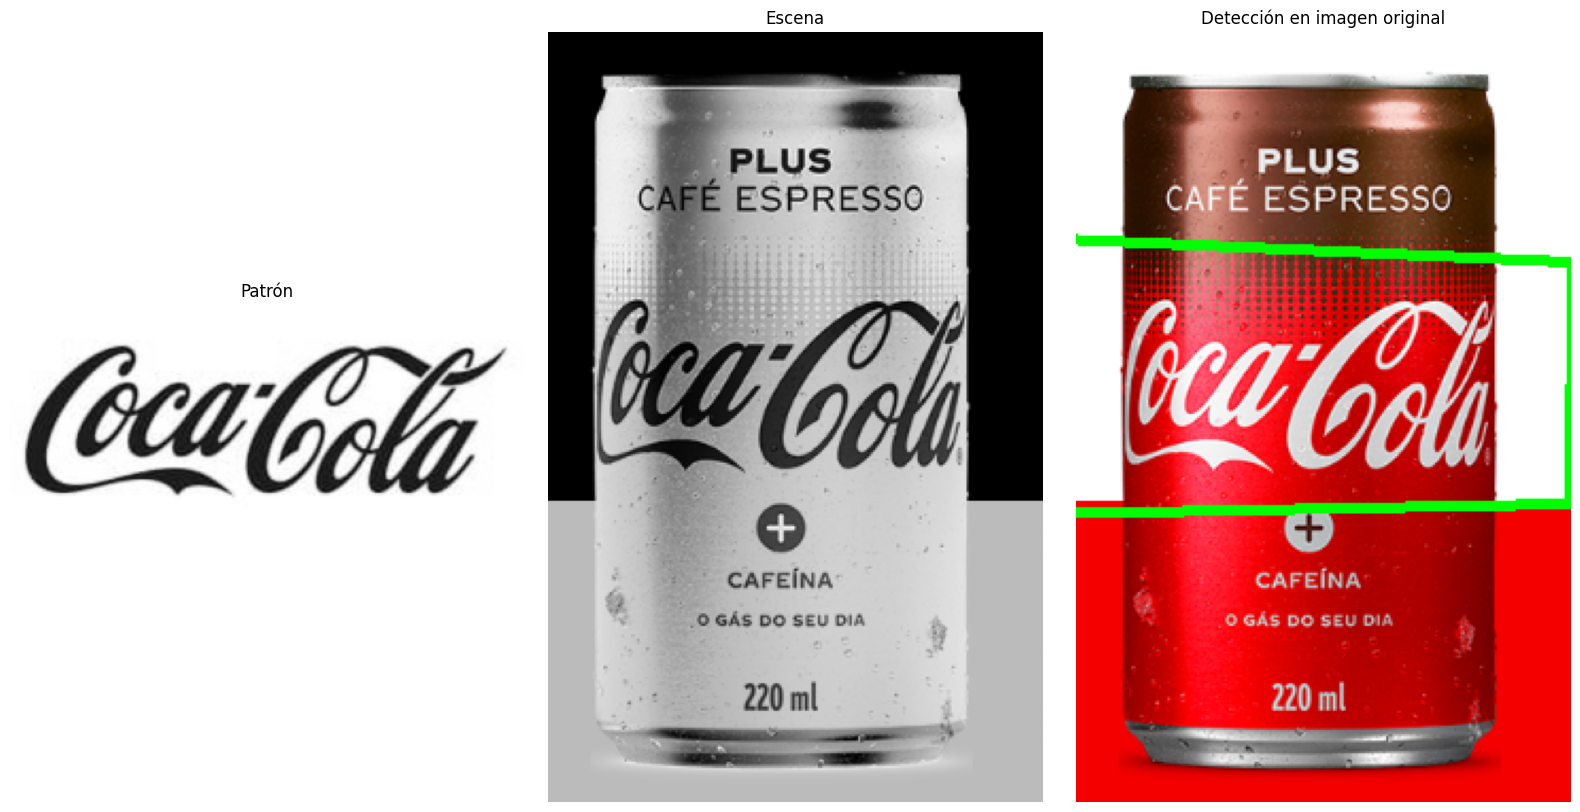

El mejor valor es 0.5183603167533875 con una cantidad de detecciones 82


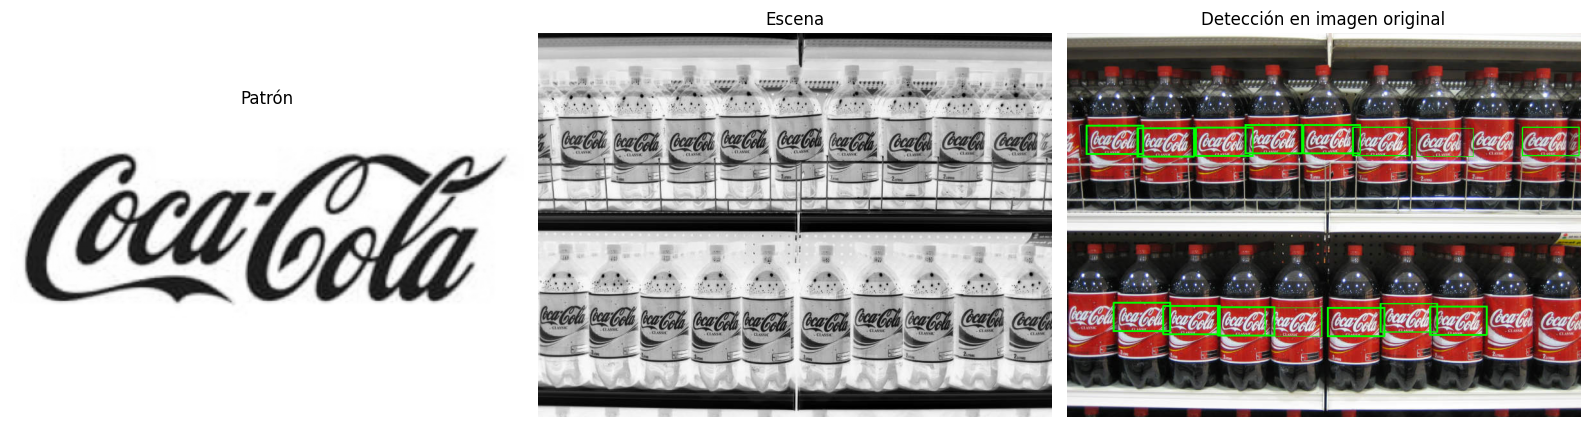

Buenos matches: 29


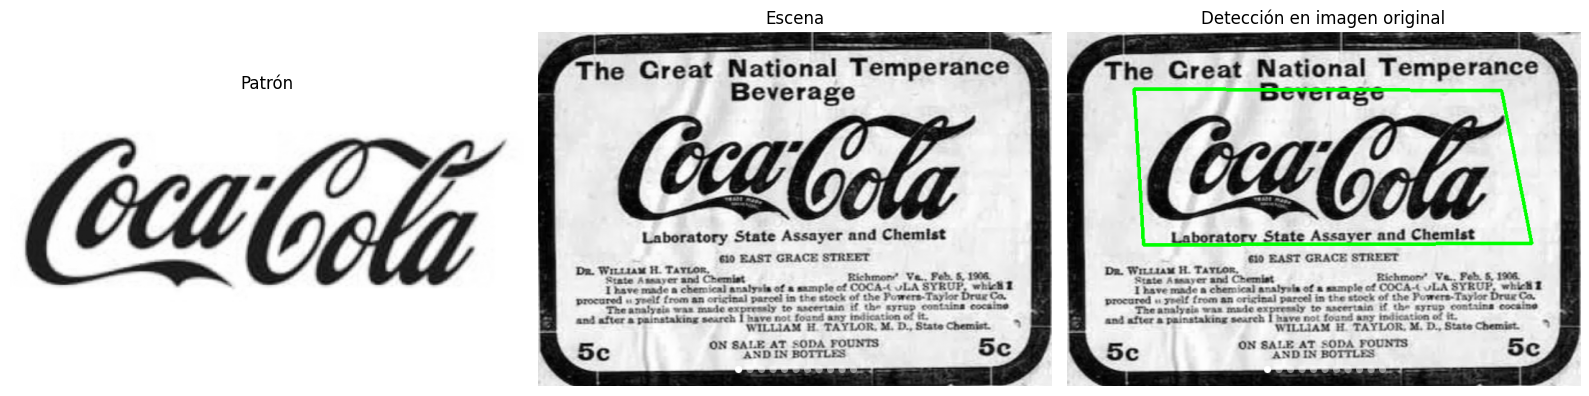

Buenos matches: 34


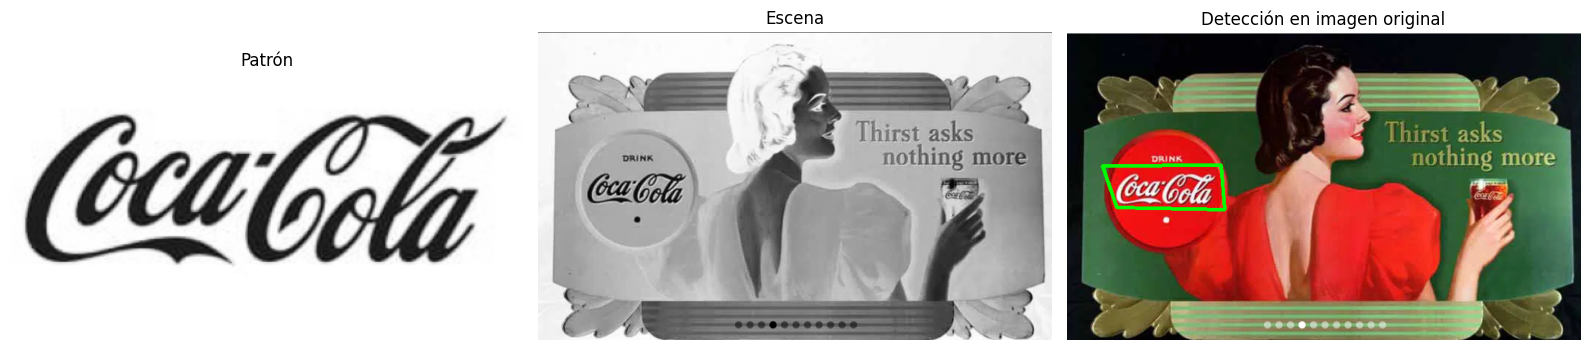

Buenos matches: 38


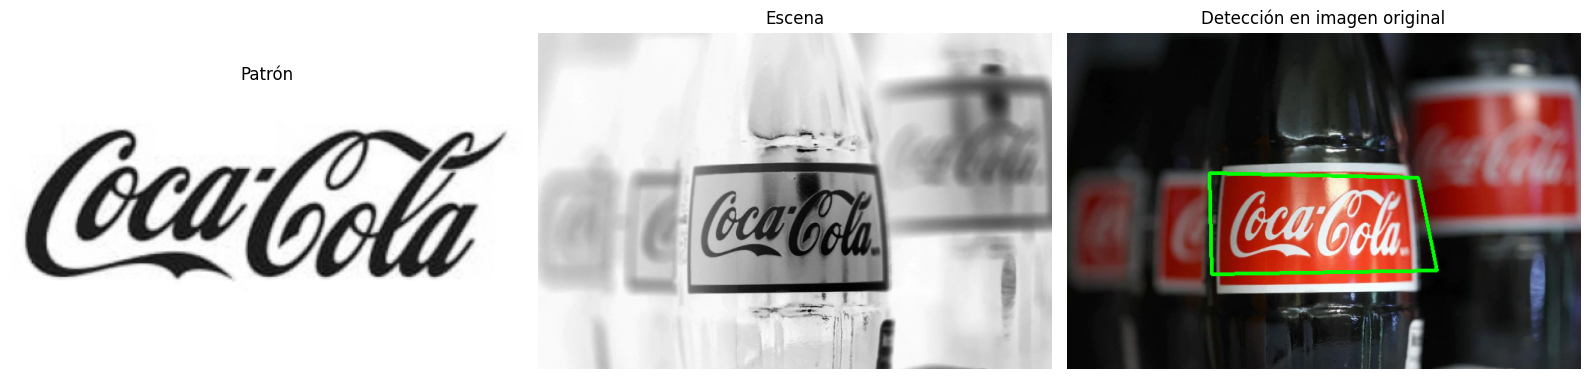

In [ ]:
def display_matching_result(scene, pattern, scene_out):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(pattern, cmap='gray')
    plt.title("Patrón")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(scene, cmap='gray')
    plt.title("Escena")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv.cvtColor(scene_out, cv.COLOR_BGR2RGB))
    plt.title("Detección en imagen original")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

image_dir = './data/images'
pattern_path = './data/template/pattern.png'
scene_path = glob.glob(os.path.join(image_dir, '*.jpg')) + glob.glob(os.path.join(image_dir, '*.png'))
scene_path.sort()

for path in scene_path:
    pattern_color = cv.imread(pattern_path)
    scene_color = cv.imread(path)

    # Convertir a escala de grises
    pattern_gray = cv.cvtColor(pattern_color, cv.COLOR_BGR2GRAY)
    scene_gray_original = cv.cvtColor(scene_color, cv.COLOR_BGR2GRAY)
    scene_gray_invertido = cv.bitwise_not(scene_gray_original)
    sift_success = False
    for scene_gray in [scene_gray_original, scene_gray_invertido]:
        # Inicializar SIFT
        sift = cv.SIFT_create()

        # Keypoints y descriptores
        kp1, des1 = sift.detectAndCompute(pattern_gray, None)
        kp2, des2 = sift.detectAndCompute(scene_gray, None)

        # Matching con FLANN + ratio test
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)

        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches_knn = flann.knnMatch(des1, des2, k=2)

        # Filtrar buenos matches
        good_matches = [m for m, n in matches_knn if m.distance < 0.75 * n.distance]

        # Si hay suficientes, estimar homografía
        if len(good_matches) >= 10:
            print(f"Buenos matches: {len(good_matches)}")
            src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

            if M is not None:
                sift_success = True
                h, w = pattern_gray.shape
                pts = np.float32([[0,0],[0,h],[w,h],[w,0]]).reshape(-1,1,2)
                dst = cv.perspectiveTransform(pts, M)

                # Dibujar en la imagen original
                scene_out = scene_color.copy()
                scene_out = cv.polylines(scene_out, [np.int32(dst)], True, (0,255,0), 3)
                display_matching_result(scene_gray, pattern_gray, scene_out)
            else:
                print(f"Homografía no encontrada para la imagen {path}")
    if not sift_success:
        result = template_matching_fallback(scene_gray, pattern_gray)
        scene_out = scene_color.copy()
        for pt in zip(*result['loc'][::-1]):
            bottom_right = (pt[0] + result['w'], pt[1] + result['h'])
            cv.rectangle(scene_out, pt, bottom_right, (0, 255, 0), 1)
        display_matching_result(scene_gray, pattern_gray, scene_out)